In [1]:
!pip install ultralytics matplotlib opencv-python scikit-learn pandas seaborn

  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [2]:

#install/import all the libraries 

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from IPython.display import display, Image
import yaml

In [3]:
random.seed(42)
np.random.seed(42)

In [5]:
BASE_PATH = "./yolov8dataset"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALID_PATH = os.path.join(BASE_PATH, "valid")
TEST_PATH = os.path.join(BASE_PATH, "test")

print("Checking dataset structure:")
for folder in [TRAIN_PATH, VALID_PATH, TEST_PATH]:
    if os.path.exists(folder):
        print(f"\n{os.path.basename(folder)} folder exists")
        img_dir = os.path.join(folder, "images")
        label_dir = os.path.join(folder, "labels")
        
        if os.path.exists(img_dir) and os.path.exists(label_dir):
            num_images = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
            num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])
            print(f"  - Images: {num_images}")
            print(f"  - Labels: {num_labels}")
        else:
            print(f"  - Missing images or labels directory")
    else:
        print(f"\n{os.path.basename(folder)} folder doesn't exist")

Checking dataset structure:

train folder exists
  - Images: 7842
  - Labels: 7842

valid folder exists
  - Images: 1960
  - Labels: 1960

test folder exists
  - Images: 1051
  - Labels: 1051


In [18]:
YAML_PATH = './yolov8dataset/data.yaml'

if os.path.exists(YAML_PATH):
    print(f"\nFound existing YAML file at: {YAML_PATH}")
    # Load and display the YAML content
    with open(YAML_PATH, 'r') as file:
        yaml_content = yaml.safe_load(file)
        
    print("YAML content:")
    print(f"- Training path: {yaml_content.get('train')}")
    print(f"- Validation path: {yaml_content.get('val')}")
    print(f"- Test path: {yaml_content.get('test')}")
    print(f"- Number of classes: {yaml_content.get('nc')}")
    print("- Class names:")
    for i, name in enumerate(yaml_content.get('names', [])):
        print(f"  {i}: {name}")
else:
    print(f"\nWARNING: YAML file not found at {YAML_PATH}")
    print("Creating a simple YAML file as fallback")
    # Create a simple YAML as fallback
    yaml_content = {
        'train': './train/images',
        'val': './valid/images',
        'test': './test/images',
        'nc': 10,
        'names': [
            'Tomato Bacterial Spot', 
            'Tomato Early blight', 
            'Tomato Late blight', 
            'Tomato Leaf Mold', 
            'Tomato Septoria leaf spot', 
            'Tomato Spider mites Two-spotted spider mite', 
            'Tomato Target Spot', 
            'Tomato Yellow Leaf Curl Virus', 
            'Tomato healthy', 
            'Tomato mosaic virus'
        ]
    }
    
    with open('data.yaml', 'w') as file:
        yaml.dump(yaml_content, file)
    
    print(f"Created fallback YAML at: {YAML_PATH}")


Found existing YAML file at: ./yolov8dataset/data.yaml
YAML content:
- Training path: C:/Users/Admin/Documents/GitHub/DADN/yolov8dataset/train/images
- Validation path: C:/Users/Admin/Documents/GitHub/DADN/yolov8dataset/valid/images
- Test path: C:/Users/Admin/Documents/GitHub/DADN/yolov8dataset/test/images
- Number of classes: 10
- Class names:
  0: Tomato Bacterial Spot
  1: Tomato Early blight
  2: Tomato Late blight
  3: Tomato Leaf Mold
  4: Tomato Septoria leaf spot
  5: Tomato Spider mites Two-spotted spider mite
  6: Tomato Target Spot
  7: Tomato Yellow Leaf Curl Virus
  8: Tomato healthy
  9: Tomato mosaic virus



Sample images from training set:


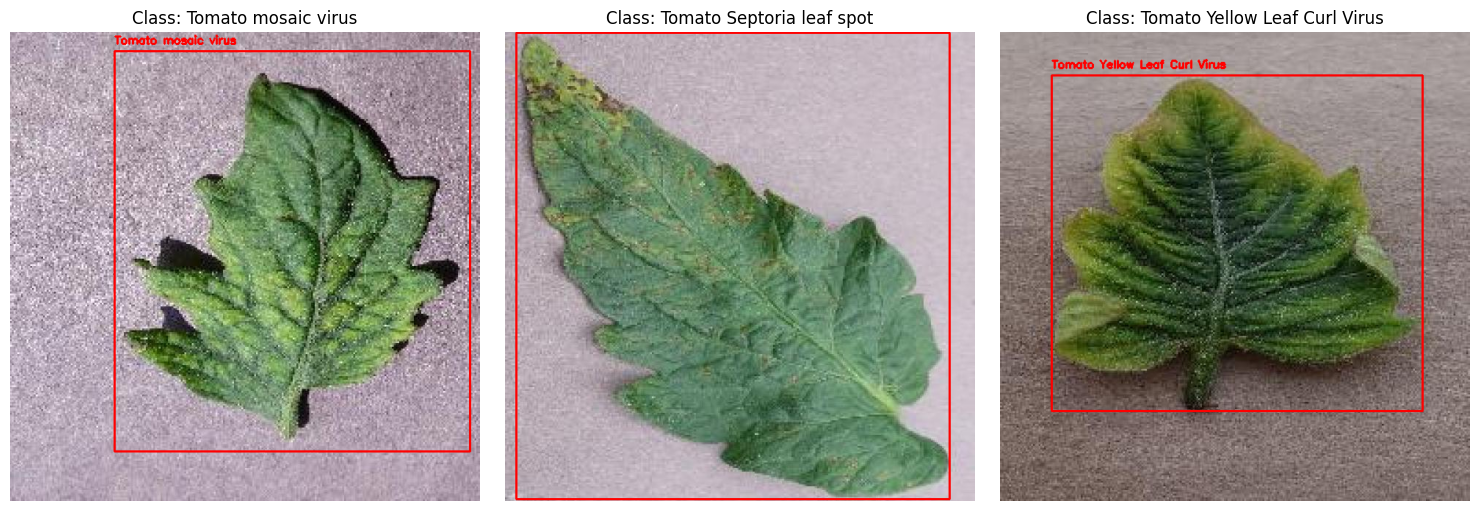

In [19]:
def plot_sample_images(folder, num_samples=3):
    """Plot sample images with bounding boxes from the dataset"""
    img_dir = os.path.join(folder, "images")
    label_dir = os.path.join(folder, "labels")
    
    # Get a list of image files
    img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if not img_files:
        print("No images found.")
        return
    
    # Randomly select files
    selected_files = random.sample(img_files, min(num_samples, len(img_files)))
    
    # Get class names from YAML
    class_names = yaml_content.get('names', [])
    
    fig, axes = plt.subplots(1, len(selected_files), figsize=(15, 5))
    if len(selected_files) == 1:
        axes = [axes]
    
    for i, img_file in enumerate(selected_files):
        # Load image
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Load corresponding label if exists
        label_file = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
        title = os.path.basename(img_file)
        
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            # Draw bounding boxes
            for line in lines:
                data = line.strip().split()
                class_id = int(data[0])
                x_center, y_center, width, height = map(float, data[1:5])
                
                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                
                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                
                # Add class name
                if class_id < len(class_names):
                    label = class_names[class_id]
                    title = f"Class: {label}"
                    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Display image
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images from training set
print("\nSample images from training set:")
plot_sample_images(TRAIN_PATH, num_samples=3)

In [17]:
import torch

# Kiểm tra nếu GPU có sẵn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}")


import os

train_images_dir = "C:/Users/Admin/Documents/GitHub/DADN/yolov8dataset/train/images"
valid_images_dir = "C:/Users/Admin/Documents/GitHub/DADN/yolov8dataset/valid/images"
test_images_dir = "C:/Users/Admin/Documents/GitHub/DADN/yolov8dataset/test/images"

# Kiểm tra xem các thư mục có chứa ảnh không
print("Train images:", os.listdir(train_images_dir))
print("Valid images:", os.listdir(valid_images_dir))
print("Test images:", os.listdir(test_images_dir))


Training on device: cuda
Train images: ['000bf685-b305-408b-91f4-37030f8e62db___GH_HL-Leaf-308_1_JPG.rf.d9d8d3cdef1e171d065de2aaac062918.jpg', '000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG-2169_JPG.rf.3bd8fefc395f458bbd4266ee55f76af5.jpg', '002213fb-b620-4593-b9ac-6a6cc119b100___Com_G_TgS_FL-8360_JPG.rf.ada35b2c0fcb37e566c65fb9bcad78b4.jpg', '002533c1-722b-44e5-9d2e-91f7747b2543___Keller_St_CG-1831_JPG.rf.30675e851ed0e4ab61eaaf0723c8b847.jpg', '002835d1-c18e-4471-aa6e-8d8c29585e9b___Com_G_SpM_FL-8584_JPG.rf.779b44dc2ed46cf5e35959e8d17436eb.jpg', '0044d10f-7062-4655-8abd-9fffc5b2f152___Com_G_TgS_FL-7908_JPG.rf.91230a7b85b45fcf74346e1717f45b14.jpg', '00694db7-3327-45e0-b4da-a8bb7ab6a4b7___Crnl_L_Mold-6923_JPG.rf.a0a1de1091dfb33a7ae221bffd63ae49.jpg', '006e354b-c054-4b72-a83c-e3feb038942e___PSU_CG-2330_JPG.rf.8dff83c3ce22a4f056ac66640306ebc9.jpg', '00854623-ba28-446d-a1d5-03c0ae3f99d9___Com_G_TgS_FL-7949_JPG.rf.d8e640d95a7d8d111d927c86cfeb4bea.jpg', '00bc7858-1dca-4bfb-a828-225f03bd72a5_

In [20]:
#train the model

def train_yolo_model(yaml_path, epochs=10, imgsz=640, batch_size=16):
    """Train YOLOv8 model on the tomato leaf dataset"""
    
    print("\n--- Starting YOLOv8 Training ---")
    
    # Initialize the model
    model = YOLO('yolov8n.pt')  # Load a pretrained YOLOv8 nano model
    
    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        patience=5,
        name='tomato_disease_model',
        device=device
    )
    
    print("--- Training Completed ---")
    return model

# Train the model (reduce epochs for demonstration if needed) - NOTE: I used the T4x2 accelerator on this, it doesn't run with just the Kaggle CPU. Thought in hindsight I think you only needed one GPU for this task.
model = train_yolo_model(YAML_PATH, epochs=10)


--- Starting YOLOv8 Training ---
New https://pypi.org/project/ultralytics/8.3.107 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.95  Python-3.12.6 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolov8dataset/data.yaml, epochs=10, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=tomato_disease_model4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fals

100%|██████████| 5.35M/5.35M [00:00<00:00, 14.0MB/s]


AMP: checks passed 


train: Scanning C:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\train\labels... 7842 images, 124 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:17<00:00, 450.91it/s]


train: New cache created: C:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\train\labels.cache


val: Scanning C:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\valid\labels... 1960 images, 37 backgrounds, 0 corrupt: 100%|██████████| 1960/1960 [00:05<00:00, 356.93it/s]


val: New cache created: C:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\valid\labels.cache
Plotting labels to runs\detect\tomato_disease_model4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\tomato_disease_model4
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.99G     0.5747      2.628       1.37          2        640: 100%|██████████| 491/491 [01:47<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:18<00:00,  3.44it/s]


                   all       1960       1924       0.76      0.571      0.773      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.42G     0.4757      1.308      1.251          2        640: 100%|██████████| 491/491 [01:54<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  4.10it/s]

                   all       1960       1924      0.803        0.5      0.759      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.42G     0.4497      0.896      1.216          2        640: 100%|██████████| 491/491 [01:56<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.93it/s]

                   all       1960       1924      0.665      0.706      0.835      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.44G     0.4214     0.6883      1.188          2        640: 100%|██████████| 491/491 [01:55<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.94it/s]

                   all       1960       1924      0.748      0.823      0.854      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.46G      0.399     0.5726      1.168          2        640: 100%|██████████| 491/491 [01:55<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.97it/s]

                   all       1960       1924      0.872      0.816      0.912      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.47G     0.3833        0.5      1.153          2        640: 100%|██████████| 491/491 [01:55<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.98it/s]

                   all       1960       1924      0.736      0.842      0.794      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.48G     0.3677     0.4391      1.137          2        640: 100%|██████████| 491/491 [01:56<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.99it/s]

                   all       1960       1924      0.811      0.917      0.848       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.51G     0.3569      0.394      1.129          2        640: 100%|██████████| 491/491 [01:55<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.98it/s]

                   all       1960       1924      0.852      0.883      0.971      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.52G      0.338     0.3466      1.115          2        640: 100%|██████████| 491/491 [02:15<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:22<00:00,  2.78it/s]

                   all       1960       1924      0.945      0.851       0.96      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.54G     0.3257     0.3109      1.103          2        640: 100%|██████████| 491/491 [02:52<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:21<00:00,  2.91it/s]

                   all       1960       1924      0.851      0.912      0.916      0.804



10 epochs completed in 0.399 hours.
Optimizer stripped from runs\detect\tomato_disease_model4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\tomato_disease_model4\weights\best.pt, 6.2MB

Validating runs\detect\tomato_disease_model4\weights\best.pt...
Ultralytics 8.3.95  Python-3.12.6 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:22<00:00,  2.73it/s]


                   all       1960       1924      0.852      0.883      0.971      0.858
 Tomato Bacterial Spot        822        823      0.888      0.773      0.922       0.91
   Tomato Early blight        854        854      0.986       0.64      0.952       0.76
Tomato Yellow Leaf Curl Virus         20         20      0.409          1       0.99      0.984
        Tomato healthy        212        212      0.995          1      0.995      0.787
   Tomato mosaic virus         15         15      0.981          1      0.995      0.849
Speed: 0.3ms preprocess, 6.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\tomato_disease_model4
--- Training Completed ---


In [21]:
#model evaluation

def evaluate_model(model):
    """Evaluate the trained model on validation set"""
    
    print("\n--- Evaluating Model on Validation Set ---")
    results = model.val()
    
    # Print metrics
    print(f"mAP50: {results.box.map50:.4f}")
    print(f"mAP50-95: {results.box.map:.4f}")
    
    return results

# Evaluate the model
val_results = evaluate_model(model)


--- Evaluating Model on Validation Set ---
Ultralytics 8.3.95  Python-3.12.6 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\valid\labels.cache... 1960 images, 37 backgrounds, 0 corrupt: 100%|██████████| 1960/1960 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.01it/s]


                   all       1960       1924      0.852      0.883      0.971      0.858
 Tomato Bacterial Spot        822        823      0.888      0.773      0.921       0.91
   Tomato Early blight        854        854      0.986       0.64      0.952       0.76
Tomato Yellow Leaf Curl Virus         20         20      0.409          1       0.99      0.984
        Tomato healthy        212        212      0.995          1      0.995      0.787
   Tomato mosaic virus         15         15      0.981          1      0.995      0.849
Speed: 0.3ms preprocess, 5.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\tomato_disease_model42
mAP50: 0.9707
mAP50-95: 0.8579


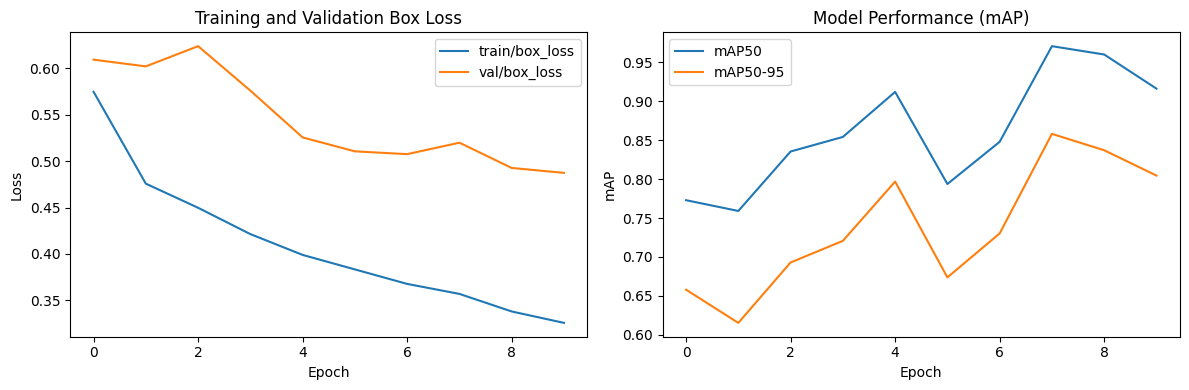

In [27]:
#visualize how training/performance went
def plot_training_metrics(model_path="C:/Users/Admin/Documents/GitHub/DADN/runs/detect/tomato_disease_model4"):
    """Plot training metrics from saved results"""
    
    results_path = os.path.join(model_path, "results.csv")
    if os.path.exists(results_path):
        results = pd.read_csv(results_path)
        
        # Plot training and validation loss
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(results['train/box_loss'], label='train/box_loss')
        plt.plot(results['val/box_loss'], label='val/box_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Box Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(results['metrics/mAP50(B)'], label='mAP50')
        plt.plot(results['metrics/mAP50-95(B)'], label='mAP50-95')
        plt.xlabel('Epoch')
        plt.ylabel('mAP')
        plt.title('Model Performance (mAP)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Results file not found at {results_path}")

# Plot training metrics
plot_training_metrics()


--- Testing Model on 3 Random Images ---

image 1/1 c:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\test\images\ed6f80a2-c69f-4d33-ad3d-ef2186aa1db1___RS_HL-9669_JPG.rf.db02188f09bbb5a8aa882dde56b8fdfd.jpg: 640x640 1 Tomato healthy, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


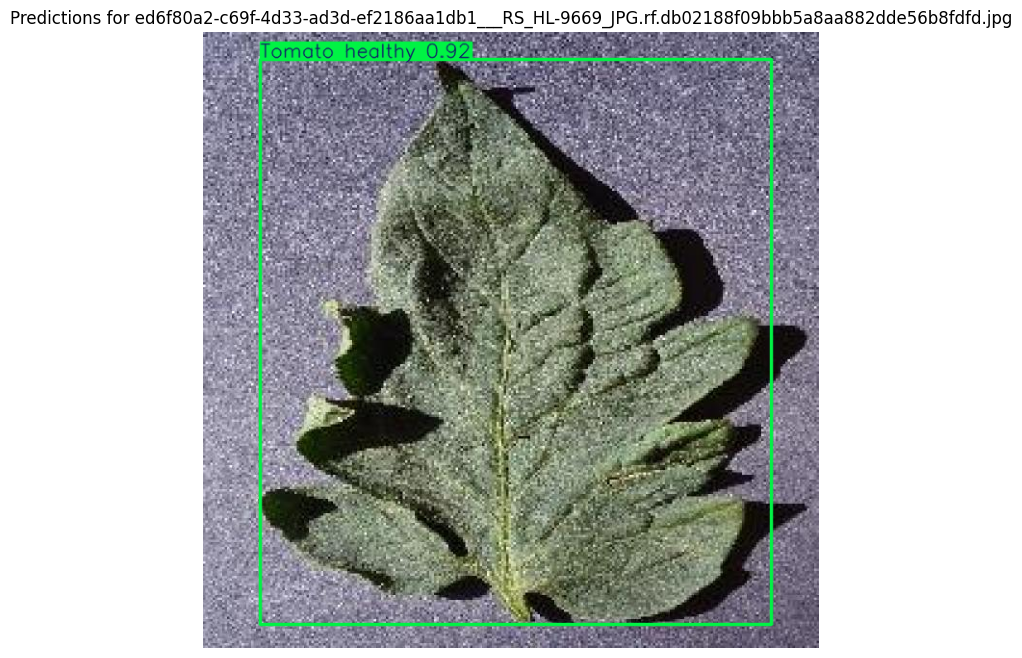


Predictions for ed6f80a2-c69f-4d33-ad3d-ef2186aa1db1___RS_HL-9669_JPG.rf.db02188f09bbb5a8aa882dde56b8fdfd.jpg:
  - Object 1: Tomato healthy, Confidence: 0.9178

image 1/1 c:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\test\images\f34d61c3-c2de-4ed5-858b-03c7b21ebcb6___RS_Late_B-5018_JPG.rf.104ac24beb9eb3a7b39ad6cdb2c38a09.jpg: 640x640 1 Tomato Early blight, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


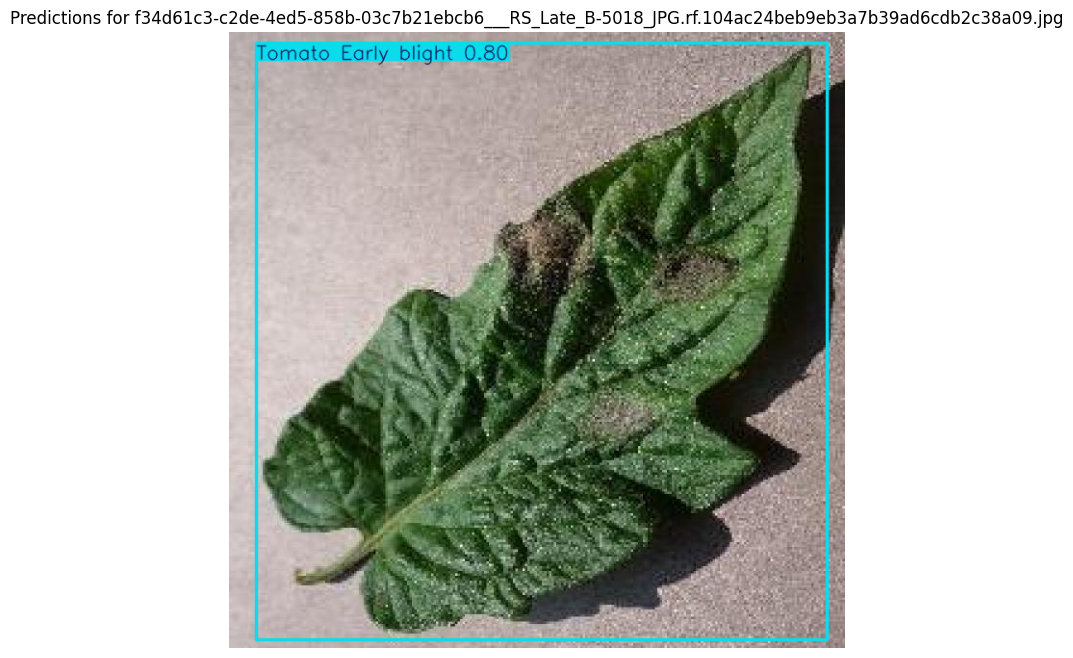


Predictions for f34d61c3-c2de-4ed5-858b-03c7b21ebcb6___RS_Late_B-5018_JPG.rf.104ac24beb9eb3a7b39ad6cdb2c38a09.jpg:
  - Object 1: Tomato Early blight, Confidence: 0.8041

image 1/1 c:\Users\Admin\Documents\GitHub\DADN\yolov8dataset\test\images\136a69f1-2cf0-4fc6-bf40-8ed63bd3db94___RS_HL-9624_JPG.rf.eabee48d438c027f4327887f1d6fad76.jpg: 640x640 1 Tomato healthy, 12.5ms
Speed: 2.5ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


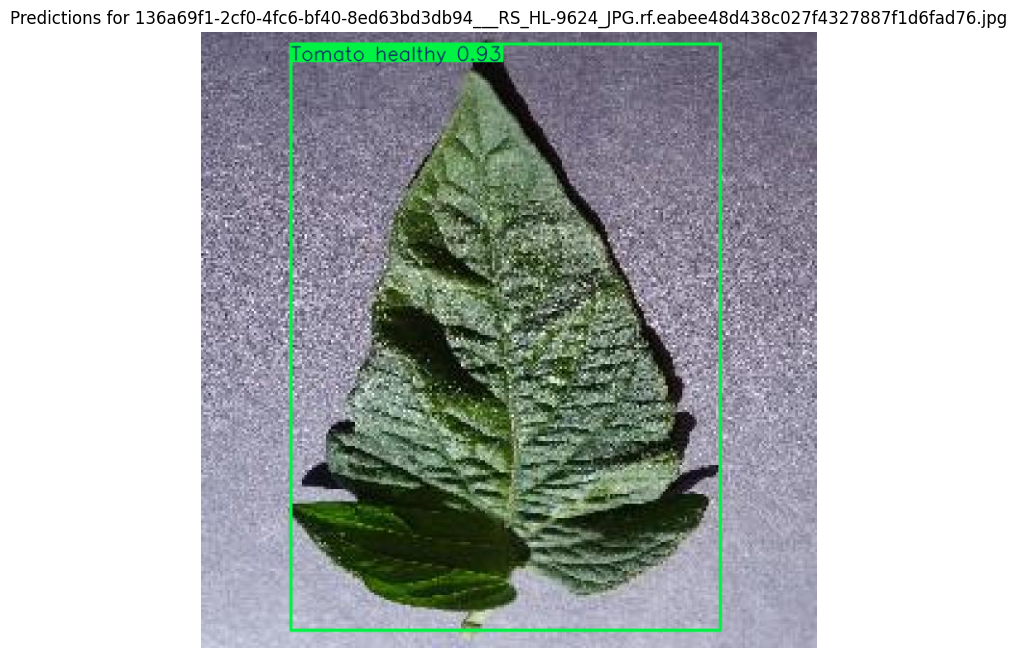


Predictions for 136a69f1-2cf0-4fc6-bf40-8ed63bd3db94___RS_HL-9624_JPG.rf.eabee48d438c027f4327887f1d6fad76.jpg:
  - Object 1: Tomato healthy, Confidence: 0.9291


In [28]:
#run the model in action
def test_on_images(model, test_dir, num_samples=5):
    """Test the model on random images from the test set"""
    
    test_img_dir = os.path.join(test_dir, "images")
    test_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if not test_files:
        print("No test images found.")
        return
    
    # Randomly select files
    selected_files = random.sample(test_files, min(num_samples, len(test_files)))
    
    print(f"\n--- Testing Model on {len(selected_files)} Random Images ---")
    
    for img_file in selected_files:
        img_path = os.path.join(test_img_dir, img_file)
        
        # Run prediction
        results = model.predict(img_path, conf=0.25)
        
        # Get the image with predictions
        result_img = results[0].plot()
        
        # Display image
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Predictions for {img_file}")
        plt.axis('off')
        plt.show()
        
        # Show prediction details
        print(f"\nPredictions for {img_file}:")
        boxes = results[0].boxes
        for i, box in enumerate(boxes):
            cls = int(box.cls[0].item())
            conf = box.conf[0].item()
            class_name = model.names[cls]
            print(f"  - Object {i+1}: {class_name}, Confidence: {conf:.4f}")

# Test the model on random images
test_on_images(model, TEST_PATH, num_samples=3)

In [32]:
#OPTIONAL - download the model for future use, if you're running this in a local jupyter notebook

def save_final_model(model, output_path='tomato_disease_detector_new.pt'):
    """Save the trained model for future use"""
    model.export(format='torchscript')
    model.save('tomato_disease_model_final.pt')
    # print(f"\nModel saved to: {os.path.join(model.export_dir, model.export_filename)}")

# Save the model
save_final_model(model)

Ultralytics 8.3.95  Python-3.12.6 torch-2.6.0+cu126 CPU (AMD Ryzen 7 6800H with Radeon Graphics)

PyTorch: starting from 'runs\detect\tomato_disease_model4\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (6.0 MB)

TorchScript: starting export with torch 2.6.0+cu126...
TorchScript: export success  1.7s, saved as 'runs\detect\tomato_disease_model4\weights\best.torchscript' (11.9 MB)

Export complete (2.0s)
Results saved to C:\Users\Admin\Documents\GitHub\DADN\runs\detect\tomato_disease_model4\weights
Predict:         yolo predict task=detect model=runs\detect\tomato_disease_model4\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs\detect\tomato_disease_model4\weights\best.torchscript imgsz=640 data=./yolov8dataset/data.yaml  
Visualize:       https://netron.app


In [3]:
import torch
from PIL import Image
from torchvision import transforms

def load_model(model_path='./model_output/model_final.pt'):
    """Load the saved model for inference"""
    model = torch.jit.load(model_path)
    model.eval()  # Set the model to evaluation mode
    return model

def prepare_image(image_path):
    """Prepare the image for prediction"""
    transform = transforms.Compose([
        transforms.Resize((640, 640)),  # Resize to the input size of your model
        transforms.ToTensor(),          # Convert to Tensor
        transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])  # Normalize if needed
    ])
    
    # Open the image
    image = Image.open(image_path)
    
    # Apply the transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

def predict(model, image_tensor):
    """Make a prediction using the model"""
    with torch.no_grad():  # Disable gradient calculation
        output = model(image_tensor)  # Forward pass
    return output

# Load the saved model
model_pre = YOLO('tomato_disease_model_final.pt') 

# Prepare a new image for prediction
# image_tensor = prepare_image('./archive/img/OIP.jpg')  # Replace with your image path

# # Make a prediction
# prediction = predict(model_pre, image_tensor)

# # Print or process the prediction
# print(prediction)



0: 640x640 1 Tomato Early blight, 11.4ms
Speed: 0.7ms preprocess, 11.4ms inference, 141.3ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Tomato Bacterial Spot', 1: 'Tomato Early blight', 2: 'Tomato Late blight', 3: 'Tomato Leaf Mold', 4: 'Tomato Septoria leaf spot', 5: 'Tomato Spider mites Two-spotted spider mite', 6: 'Tomato Target Spot', 7: 'Tomato Yellow Leaf Curl Virus', 8: 'Tomato healthy', 9: 'Tomato mosaic virus'}
obb: None
orig_img: array([[[ 63,  89,  28],
        [ 65,  91,  30],
        [ 66,  91,  30],
        ...,
        [116,  69,  49],
        [121,  73,  52],
        [121,  73,  51]],

       [[ 40,  64,   4],
        [ 49,  73,  13],
        [ 60,  83,  23],
        ...,
        [118,  70,  49],
        [122,  74,  52],
        [122,  74,  52]],

       [[ 98, 120,  58],
        [ 96, 119,  57],
        [ 93, 115,  53]


0: 640x640 1 Tomato Early blight, 6.9ms
1: 640x640 1 Tomato Early blight, 6.9ms
2: 640x640 1 Tomato Early blight, 6.9ms
3: 640x640 1 Tomato Early blight, 6.9ms
Speed: 31.2ms preprocess, 6.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


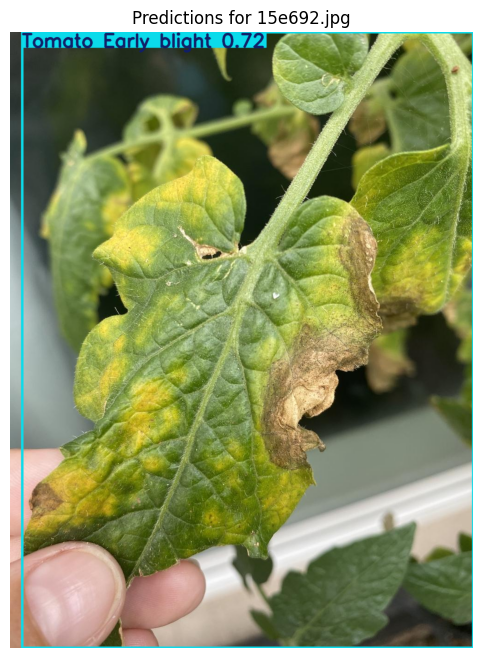


Predictions for 15e692.jpg:
  - Object 1: Tomato Early blight, Confidence: 0.7199


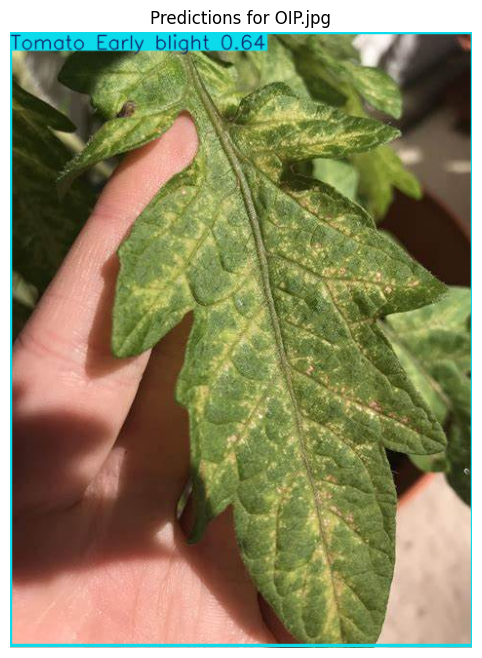


Predictions for OIP.jpg:
  - Object 1: Tomato Early blight, Confidence: 0.6445


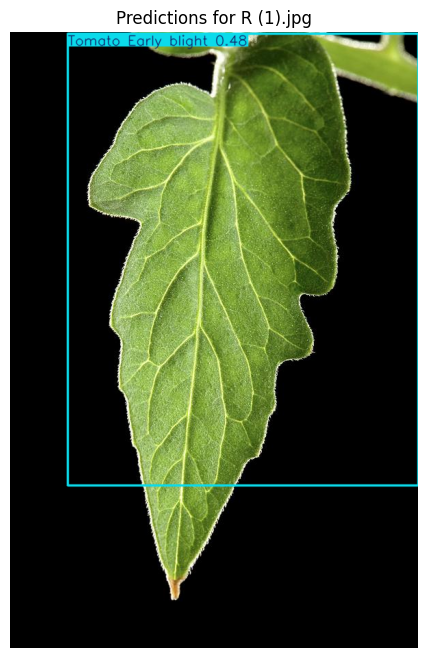


Predictions for R (1).jpg:
  - Object 1: Tomato Early blight, Confidence: 0.4784


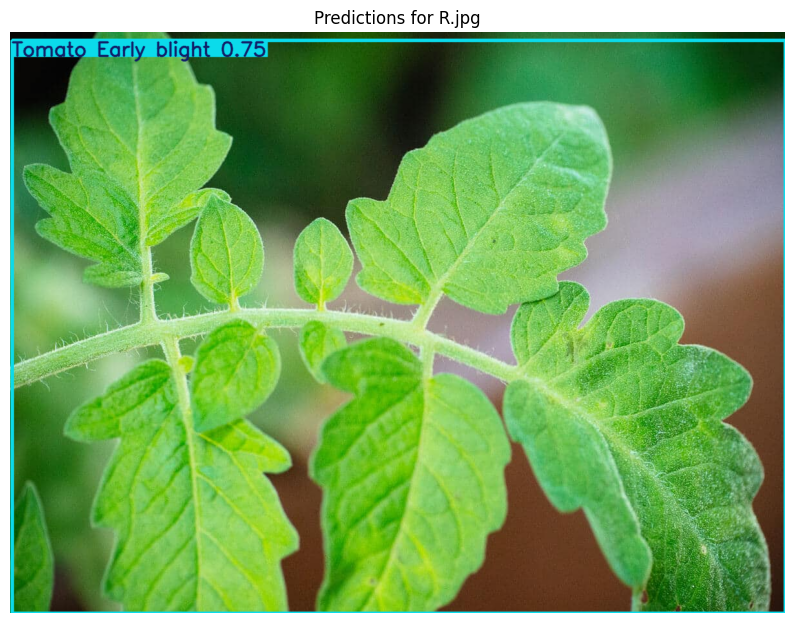


Predictions for R.jpg:
  - Object 1: Tomato Early blight, Confidence: 0.7457


In [12]:
def test_batch(model, test_dir, batch_size=5):
    """Test the model on a batch of images"""
    test_img_dir = os.path.join(test_dir, "images")
    test_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not test_files:
        print("No test images found.")
        return

    # Chia thành các nhóm (batch) và chạy dự đoán cho từng nhóm
    for i in range(0, 10 if len(test_files) > 10 else len(test_files) , batch_size):
        batch_files = test_files[i:i+batch_size]
        batch_paths = [os.path.join(test_img_dir, file) for file in batch_files]
        
        # Run prediction for batch
        results = model.predict(batch_paths, conf=0.25)
        
        # Display the results for the batch
        for result, img_file in zip(results, batch_files):
            result_img = result.plot()
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Predictions for {img_file}")
            plt.axis('off')
            plt.show()
            # You can also print details for each result
            print(f"\nPredictions for {img_file}:")
            for i, box in enumerate(result.boxes):
                cls = int(box.cls[0].item())
                conf = box.conf[0].item()
                class_name = model.names[cls]
                print(f"  - Object {i+1}: {class_name}, Confidence: {conf:.4f}")
test_batch(model_pre,
        #    './yolov8dataset/test/'
           './archive/'
           )